In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
df = pd.read_csv('full_data.csv', index_col=[0])

In [3]:
df.head()

,tweet_text
0,Islam is a religion full of blessings and good...
1,@ wagner_claire Religion and pity are antonyms...
2,if the only reason people are on twitter is to...
3,@15MeterClassYas @NotoriousDachi is there such...
4,Religion is needed to provide a moral compass ...


In [4]:
df.shape

(57371, 1)

In [7]:
df['tweet_text'] = df['tweet_text'].apply(str)    #Convert tweet to string

In [8]:
df.drop_duplicates(subset=['tweet_text'], keep='first', inplace=True)      #Checking for duplicates and removing them
df.shape

(53939, 1)

In [9]:
count = df['tweet_text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)

In [10]:
print("Total number of words:", count.sum(), "words")

Total number of words: 1350392 words


In [11]:
print("Mean number of words per tweet:", round(count.mean(),2), "words")

Mean number of words per tweet: 25.04 words


In [12]:
df["tweet_length"] = df["tweet_text"].str.len()
print("Total length of the dataset is:", df.tweet_length.sum(), "characters")

Total length of the dataset is: 8278911 characters


In [13]:
print("Mean Length of a tweet is:", round(df.tweet_length.mean(),0), "characters")
df = df.drop(['tweet_length'], axis=1)

Mean Length of a tweet is: 153.0 characters


In [14]:
#Removing tweet handles
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [15]:
df['tidy_tweet'] = np.vectorize(remove_users)(df['tweet_text'], "@ [\w]*", "@[\w]*")

In [16]:
df['tidy_tweet'] = df['tidy_tweet'].str.lower()

In [17]:
df['hashtags'] = df['tidy_tweet'].apply(lambda twt : re.findall(r"# (\w+)", twt))

In [18]:
d = Counter(df.hashtags.sum())
df_hashtags = pd.DataFrame([d]).T

In [19]:
df_hashtags.columns = ['freq']
df_hashtags.freq.sum()

15557

In [20]:
df_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)
df

,tweet_text,tidy_tweet,hashtags
0,Islam is a religion full of blessings and good...,islam is a religion full of blessings and good...,[]
1,@ wagner_claire Religion and pity are antonyms...,religion and pity are antonyms. one is disast...,[]
2,if the only reason people are on twitter is to...,if the only reason people are on twitter is to...,[]
3,@15MeterClassYas @NotoriousDachi is there such...,is there such thing as science v religion?,[]
4,Religion is needed to provide a moral compass ...,religion is needed to provide a moral compass ...,[tytlive]
...,...,...,...
57366,Now all you have is programs of religion being...,now all you have is programs of religion being...,[]
57367,Morality is defined by conscience rather than ...,morality is defined by conscience rather than ...,[]
57368,Persecution of vulnerable minorities can be as...,persecution of vulnerable minorities can be as...,[]
57369,With his clerical fascism. Though the Catholic...,with his clerical fascism. though the catholic...,[]


In [21]:
df_hashtags.head(20)

,freq
religion,1220
islam,328
atheism,199
god,151
faith,144
atheist,141
christianity,97
jesus,94
bible,83
quote,80


In [22]:
# We drop 'religion' and 'is' hashtags as these were the searching filters
df_hashtags = df_hashtags.drop(df_hashtags[df_hashtags.index.values=='religion'].index)
df_hashtags = df_hashtags.drop(df_hashtags[df_hashtags.index.values=='is'].index)

Among 53939 Tweets, 15557 Hashtags were used.


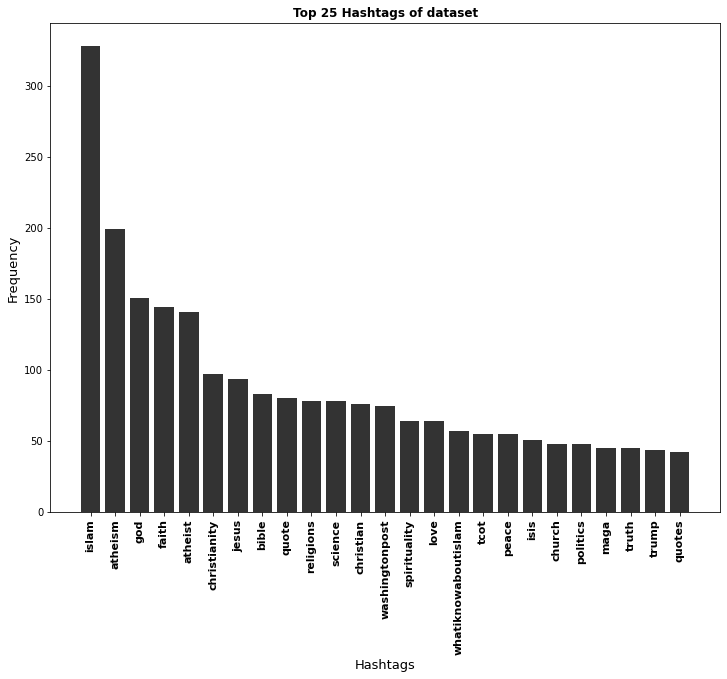

In [23]:
#Top 25 Hashtags
labels = df_hashtags.head(25).index.values.tolist()
freq = df_hashtags['freq'].head(25).values.tolist()
index = np.arange(len(freq))

print("Among 53939 Tweets, 15557 Hashtags were used.")
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Hashtags', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, labels, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Hashtags of dataset', fontsize=12, fontweight="bold")
plt.show()

In [24]:
df = df.drop(['hashtags'], axis=1) #Remove hashtag coloum

In [25]:
def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [26]:
df['tidy_tweet'] = np.vectorize(remove_hashtags)(df['tidy_tweet'], "# [\w]*", "#[\w]*")

In [27]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [28]:
df['tidy_tweet'] = np.vectorize(remove_links)(df['tidy_tweet'])

In [29]:
#Removing word - 'Religion', 'Religious'
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [30]:
df['tidy_tweet'] = np.vectorize(remove_word)(df['tidy_tweet'], "religion", "religiou")

In [31]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-31-42c580297310>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")


In [32]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #Remove short words

In [33]:
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # deacc=True Removes punctuations

In [34]:
df['tidy_tweet_tokens'] = list(tokenize(df['tidy_tweet']))

In [35]:
# Prepare Stop Words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter', 'religions', 'pic','twitt',])

In [36]:
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

In [37]:
df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])

In [38]:
#Drop rows having less than three tokens
df['length'] = df['tokens_no_stop'].apply(len)
df = df.drop(df[df['length']<3].index)

In [39]:
df = df.drop(['length'], axis=1)
df.shape

(49458, 4)

In [40]:
df.reset_index(drop=True, inplace=True)

In [41]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words

In [42]:
df['no_stop_joined'] = df.apply(rejoin_words, axis=1)

In [43]:
all_words = ' '.join([text for text in df['no_stop_joined']])

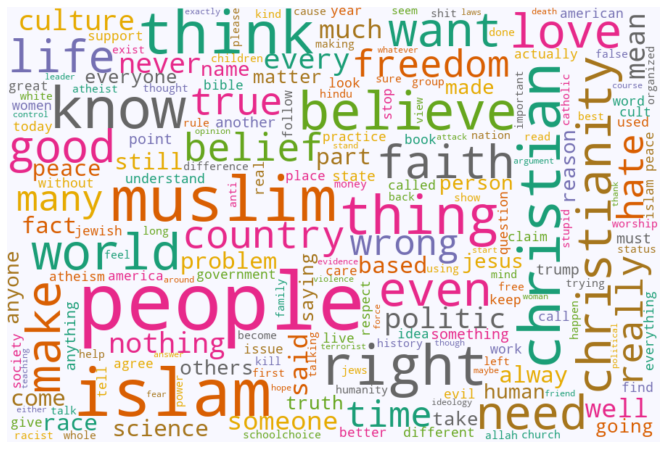

In [44]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='Dark2').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [45]:
df["tweet_length"] = df["tweet_text"].str.len()
df["cleaned_tweet_length"] = df["no_stop_joined"].str.len()
df_lengths = df[['tweet_length', 'cleaned_tweet_length']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


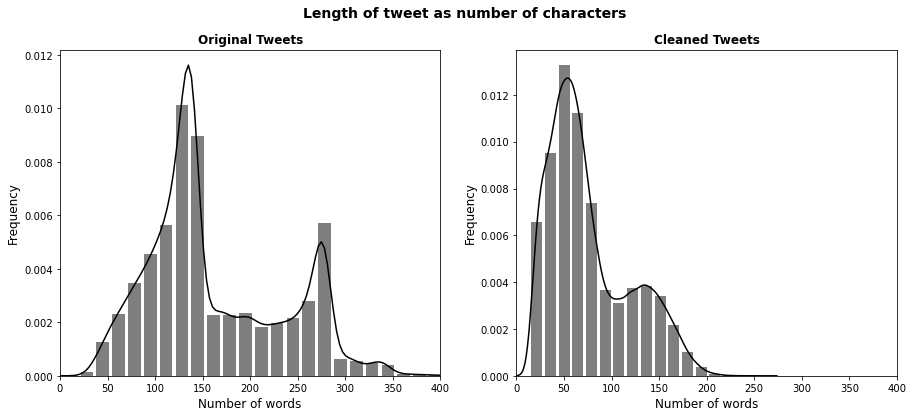

In [46]:
x1 = df_lengths.tweet_length
x2 = df_lengths.cleaned_tweet_length
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of characters', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x1, color="black", label="No. Words", bins=35, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="black", label="No. Words", bins=17, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

plt.show()

In [47]:
df["tweet_words"] = df['tweet_text'].str.split().str.len()
df["cleaned_tweet_words"] = df["no_stop_joined"].str.split().str.len()
df_lengths = df[['tweet_words', 'cleaned_tweet_words']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


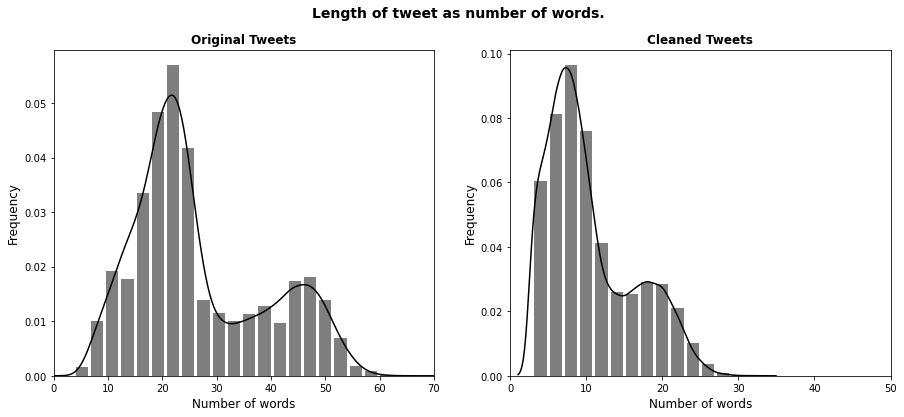

In [48]:
x_1 = df_lengths.tweet_words
x_2 = df_lengths.cleaned_tweet_words
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of words.', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x_1, color="black", label="No. Words", bins=25, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,70])



# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x_2, color="black", label="No. Words", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,50])

plt.show()

In [49]:
df = df.drop(['tweet_length', 'cleaned_tweet_length', 'tweet_words', 'cleaned_tweet_words'], axis=1)

In [50]:
word_freq = pd.Series(np.concatenate([x.split() for x in df.no_stop_joined])).value_counts()

In [51]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

Unique words: 37561


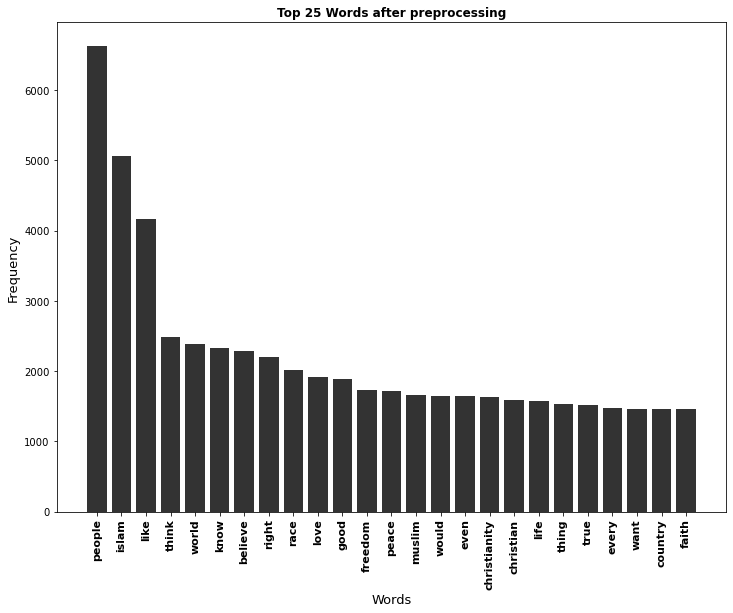

In [52]:
label = word_df['word'].head(25)
freq = word_df['freq'].head(25)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

In [51]:
df.to_pickle('pre-processed.pkl')